In [19]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import scipy
import pandas as pd 
from scipy import interpolate

In [24]:
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [3]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
        cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
        cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

# BiSON Data

In [4]:
hdul = fits.open('data/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: data/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [5]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [6]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [7]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Count

In [8]:
sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [9]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [10]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [11]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [12]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Preprocessing

In [13]:
datax_SV = getSV_index(cycle_23)
datay_SV = getSV(cycle_23)


# plt.xlabel('Time (BJD)')
# plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

# #Axis 1
# plt.autoscale(enable=True, axis='both', tight=None)
# plt.scatter(datax_SV,datay_SV, s = 10, c='blue', alpha=0.5)
# plt.show()
print(datax_SV.size)

9730800


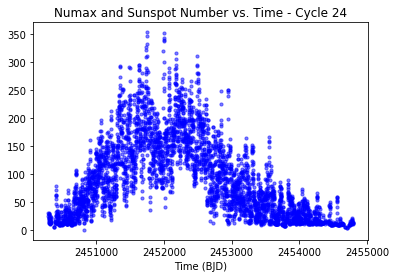

9010


In [14]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)
data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]

plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(datax_SN,datay_SN, s = 10, c='blue', alpha=0.5)
plt.show()
print(data_SN.size)

In [15]:
train_x = np.ma.masked_equal(getSV(cycle_23),0)
train_y = np.ma.masked_equal(getSN_Day(cycle_23),0).T[1]
print(train_x.shape, train_y.shape)
train_x = np.reshape(train_x, (-1, 1,2160))
print(train_x.shape)


# y = tf.keras.layers.Conv1D(32, 1, activation='relu',input_shape=train_x.shape)(train_x)
# print(y.shape)



(9730800,) (4505,)
(4505, 1, 2160)


In [29]:
keras.backend.clear_session()
model = models.Sequential()

model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
model.add(layers.Dense(128))
model.add(layers.Conv1D(32, 1, activation='relu'))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (4505, 1, 1024)           2212864   
_________________________________________________________________
dense (Dense)                (4505, 1, 128)            131200    
_________________________________________________________________
conv1d_1 (Conv1D)            (4505, 1, 32)             4128      
_________________________________________________________________
dense_1 (Dense)              (4505, 1, 1)              33        
Total params: 2,348,225
Trainable params: 2,348,225
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
history = model.fit(train_x, train_y, epochs=10,
                   validation_data=[train_x, train_y])

Train on 4505 samples, validate on 4505 samples
Epoch 1/10
4505/4505 [==============================] - 10s 2ms/sample - loss: 8.4987 - acc: 0.0728 - val_loss: -589.8593 - val_acc: 3.7423e-04
Epoch 2/10
4505/4505 [==============================] - 7s 2ms/sample - loss: -589.8593 - acc: 3.7423e-04 - val_loss: -1235.6007 - val_acc: 2.8288e-04
Epoch 3/10
4505/4505 [==============================] - 7s 2ms/sample - loss: -1235.6007 - acc: 2.8288e-04 - val_loss: -2005.6595 - val_acc: 2.2198e-04
Epoch 4/10
4505/4505 [==============================] - 7s 2ms/sample - loss: -2005.6595 - acc: 2.2198e-04 - val_loss: -2935.1504 - val_acc: 2.2198e-04
Epoch 5/10
4505/4505 [==============================] - 7s 2ms/sample - loss: -2935.1504 - acc: 2.2198e-04 - val_loss: -4062.1252 - val_acc: 2.2198e-04
Epoch 6/10
4505/4505 [==============================] - 7s 2ms/sample - loss: -4062.1252 - acc: 2.2198e-04 - val_loss: -5427.2666 - val_acc: 2.2198e-04
Epoch 7/10
4505/4505 [===========================

In [85]:
print(history.history)

{'loss': [199.88844299316406, 178.529052734375, 153.8533935546875, 133.98526000976562, 115.67385864257812, 95.59644317626953, 78.89146423339844, 65.99067687988281, 53.349430084228516, 37.470706939697266], 'acc': [0.0795768, 0.07765839, 0.07665352, 0.075070076, 0.07440016, 0.073547535, 0.07248176, 0.07199454, 0.07120282, 0.0701675], 'val_loss': [178.529052734375, 153.8533935546875, 133.98526000976562, 115.67385864257812, 95.59644317626953, 78.89146423339844, 65.99067687988281, 53.349430084228516, 37.470706939697266, 27.232019424438477], 'val_acc': [0.07765839, 0.07665352, 0.075070076, 0.07440016, 0.073547535, 0.07248176, 0.07199454, 0.07120282, 0.0701675, 0.06946713]}
